In [1]:
# ========= CELL 0: Imports & Config =========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (12, 5)

# path to your weekly CSV (10 years). expected columns: Date, Open, High, Low, Close, Adj Close (optional), Volume
DATA_PATH = Path("data\exide_weekly_10yrs.csv")  # <-- change if needed

# ========= CELL 1: Load & basic cleaning =========
df = pd.read_csv(DATA_PATH)

# Parse date and sort
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)

# Keep only required columns that exist
cols_expected = ['Date','Open','High','Low','Close','Volume']
extra_cols = [c for c in ['Adj Close'] if c in df.columns]
keep_cols = [c for c in cols_expected if c in df.columns] + extra_cols
df = df[keep_cols].copy()

# Set Date as index (optional but handy)
df = df.set_index('Date')

print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2015-09-07 00:00:00+05:30 to 2025-09-08 00:00:00+05:30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    523 non-null    float64
 1   High    523 non-null    float64
 2   Low     523 non-null    float64
 3   Close   523 non-null    float64
 4   Volume  523 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 24.5 KB
None


,Open,High,Low,Close,Volume
Date,,,,,
2015-09-07 00:00:00+05:30,134.919495,135.948384,131.206516,132.503830,305100
2015-09-14 00:00:00+05:30,132.816998,135.724747,130.938154,132.056519,4125507
2015-09-21 00:00:00+05:30,131.519717,147.579435,130.401352,142.613892,5007893
2015-09-28 00:00:00+05:30,140.377102,143.016453,135.098427,135.993118,4322600
2015-10-05 00:00:00+05:30,136.753612,142.837503,134.830017,135.993118,4990266


Duplicate index (weeks): 0
Missing per column:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Top date gaps:
 Date
7 days    522
Name: count, dtype: int64


,Open,High,Low,Close,Volume
count,523.000000,523.000000,523.000000,523.000000,5.230000e+02
mean,222.673531,229.712633,215.668567,222.854156,1.362006e+07
std,97.105020,100.862609,93.478360,97.173186,1.409920e+07
min,109.671416,113.741695,104.922769,108.766922,3.051000e+05
25%,162.417043,166.713821,156.717364,162.878876,7.310714e+06
50%,187.290178,193.035838,181.703066,186.645752,1.054400e+07
75%,243.606439,250.117746,234.090413,243.234756,1.554987e+07
max,564.929572,614.831747,554.622128,564.632263,1.766843e+08


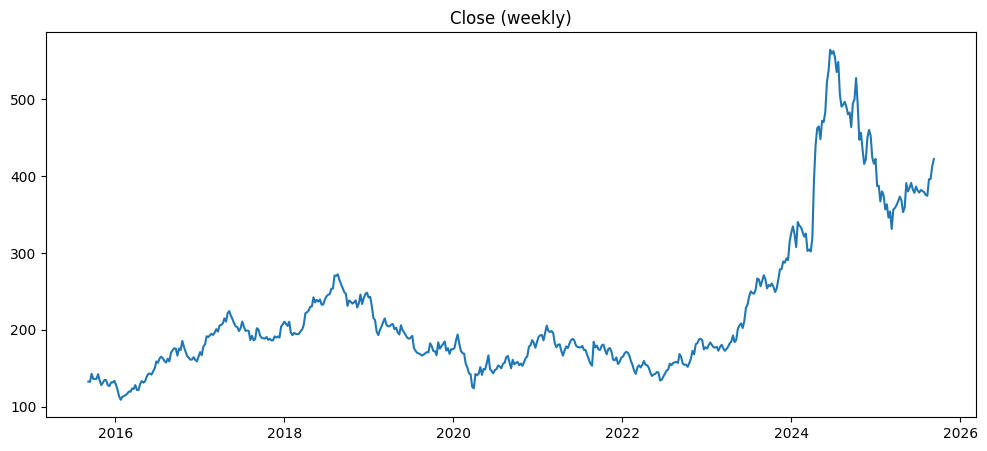

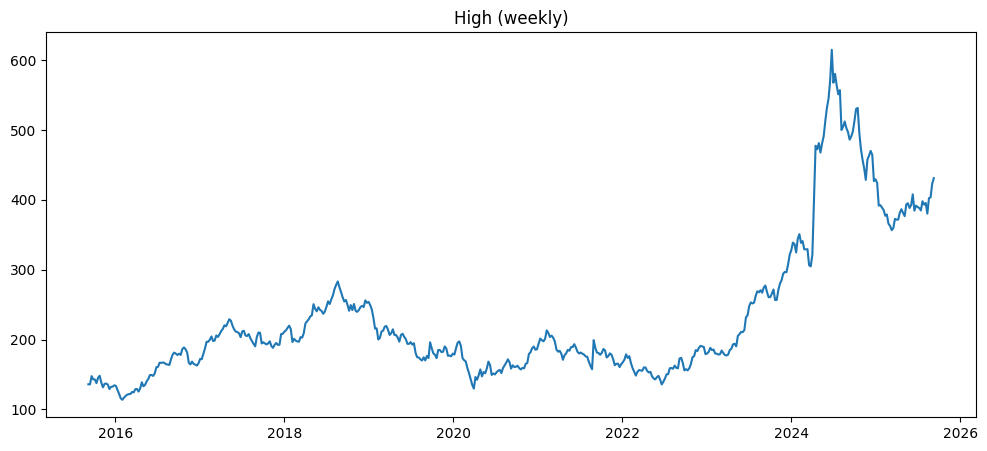

In [2]:
# ========= CELL 2: Quality checks =========
# 1) duplicates
dups = df.index.duplicated().sum()
print("Duplicate index (weeks):", dups)

# 2) missing values
print("Missing per column:\n", df.isna().sum())

# 3) weekly frequency sanity (not forcing resample, just report)
week_gaps = df.index.to_series().diff().value_counts().head(5)
print("Top date gaps:\n", week_gaps)

# 4) Outlier quick flags
desc = df[['Open','High','Low','Close','Volume']].describe()
display(desc)

# Simple visual check
fig, ax = plt.subplots()
ax.plot(df.index, df['Close'])
ax.set_title("Close (weekly)")
plt.show()

fig, ax = plt.subplots()
ax.plot(df.index, df['High'])
ax.set_title("High (weekly)")
plt.show()

# If Adj Close exists, check ratio drift
if 'Adj Close' in df.columns:
    ratio = (df['Adj Close'] / df['Close']).dropna()
    fig, ax = plt.subplots()
    ax.plot(ratio.index, ratio.values)
    ax.set_title("Adj Close / Close ratio (check splits)")
    plt.show()


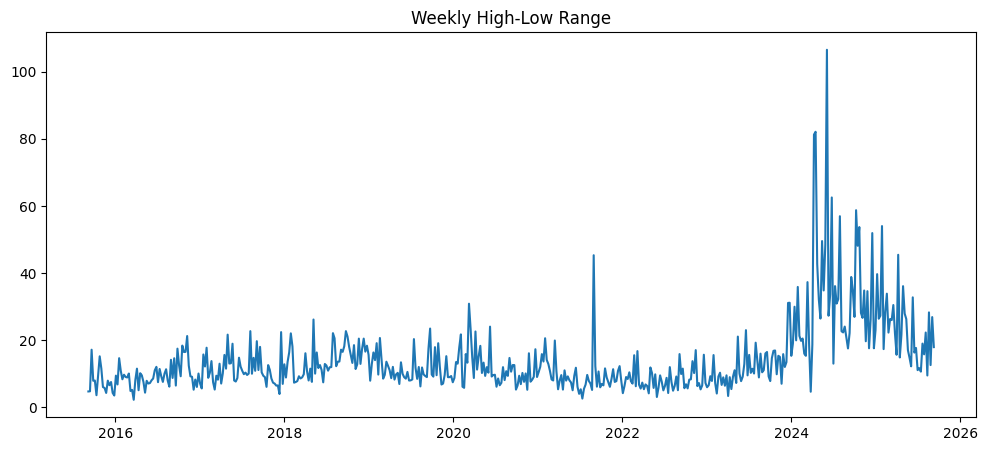

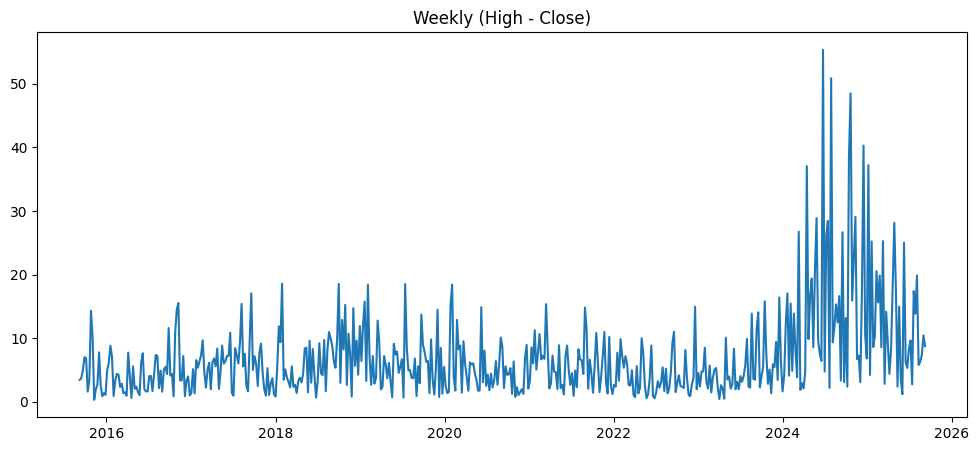

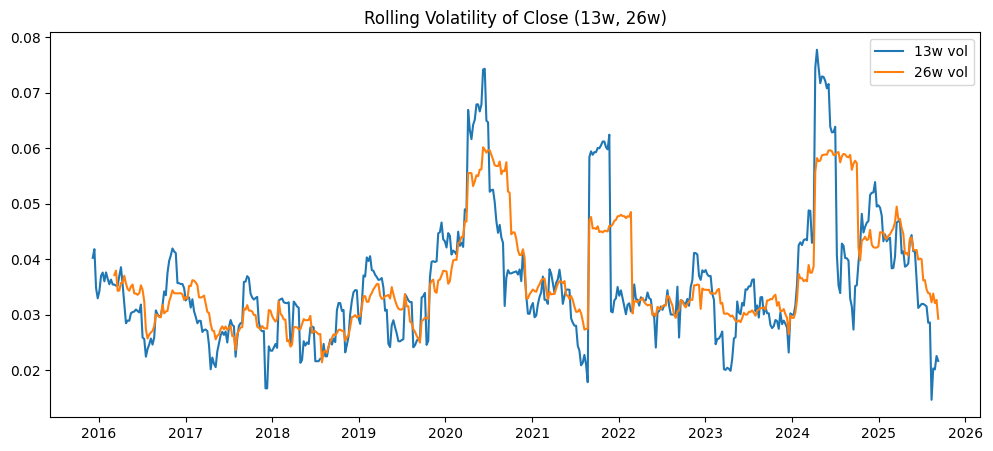

Naive baseline idea: High_{t+1} = High_t
Another baseline: High_{t+1} = Close_t + median(H-C last 52w)


In [3]:
# ========= CELL 3: EDA – Trend & Ranges =========
# Range measures
df['Range'] = df['High'] - df['Low']
df['HminusC'] = df['High'] - df['Close']

# Rolling volatilities
df['ret_close'] = np.log(df['Close']).diff()
df['vol_13w'] = df['ret_close'].rolling(13).std()
df['vol_26w'] = df['ret_close'].rolling(26).std()

# Plots
fig, ax = plt.subplots()
ax.plot(df.index, df['Range'])
ax.set_title("Weekly High-Low Range")
plt.show()

fig, ax = plt.subplots()
ax.plot(df.index, df['HminusC'])
ax.set_title("Weekly (High - Close)")
plt.show()

fig, ax = plt.subplots()
ax.plot(df.index, df['vol_13w'], label='13w vol')
ax.plot(df.index, df['vol_26w'], label='26w vol')
ax.legend()
ax.set_title("Rolling Volatility of Close (13w, 26w)")
plt.show()

# Baseline checks (we will reuse later)
print("Naive baseline idea: High_{t+1} = High_t")
print("Another baseline: High_{t+1} = Close_t + median(H-C last 52w)")


In [4]:
# ========= CELL 4: Technical indicators =========

def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(period).mean()
    ma_down = down.rolling(period).mean()
    rs = ma_up / ma_down
    rsi_ = 100 - (100 / (1 + rs))
    return rsi_

def atr(high, low, close, period=14):
    # True Range
    prev_close = close.shift(1)
    tr = np.maximum(high - low, np.maximum(abs(high - prev_close), abs(low - prev_close)))
    return tr.rolling(period).mean()

def macd(series, fast=12, slow=26, signal=9):
    ema_fast = ema(series, fast)
    ema_slow = ema(series, slow)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def stochastic_k(close, high, low, period=14):
    lowest_low = low.rolling(period).min()
    highest_high = high.rolling(period).max()
    k = 100 * (close - lowest_low) / (highest_high - lowest_low)
    return k

# Compute indicators
df['ATR14'] = atr(df['High'], df['Low'], df['Close'], period=14)
df['RSI14'] = rsi(df['Close'], period=14)
df['EMA5'] = ema(df['Close'], 5)
df['EMA10'] = ema(df['Close'], 10)
df['EMA20'] = ema(df['Close'], 20)
df['EMA50'] = ema(df['Close'], 50)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = macd(df['Close'])

df['STOCHK14'] = stochastic_k(df['Close'], df['High'], df['Low'], 14)

# Distance to 52w extremes
df['roll_max_52'] = df['High'].rolling(52).max()
df['roll_min_52'] = df['Low'].rolling(52).min()
df['dist_to_52w_high_%'] = (df['High'] / df['roll_max_52']) - 1.0
df['dist_to_52w_low_%'] = (df['Low'] / df['roll_min_52']) - 1.0

# Volume features
df['Vol_MA13'] = df['Volume'].rolling(13).mean()
df['Vol_surge'] = df['Volume'] / df['Vol_MA13']

# Clean intermediates for leakage avoidance later


In [5]:
display(df)

,Open,High,Low,Close,Volume,Range,HminusC,ret_close,vol_13w,vol_26w,...,MACD,MACD_signal,MACD_hist,STOCHK14,roll_max_52,roll_min_52,dist_to_52w_high_%,dist_to_52w_low_%,Vol_MA13,Vol_surge
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-07 00:00:00+05:30,134.919495,135.948384,131.206516,132.503830,305100,4.741868,3.444554,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-14 00:00:00+05:30,132.816998,135.724747,130.938154,132.056519,4125507,4.786593,3.668228,-0.003382,NaN,NaN,...,-0.035683,-0.007137,-0.028546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-21 00:00:00+05:30,131.519717,147.579435,130.401352,142.613892,5007893,17.178083,4.965543,0.076911,NaN,NaN,...,0.778951,0.150081,0.628870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-28 00:00:00+05:30,140.377102,143.016453,135.098427,135.993118,4322600,7.918026,7.023334,-0.047537,NaN,NaN,...,0.880166,0.296098,0.584068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-05 00:00:00+05:30,136.753612,142.837503,134.830017,135.993118,4990266,8.007487,6.844385,0.000000,NaN,NaN,...,0.949436,0.426766,0.522671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-11 00:00:00+05:30,375.649994,380.250000,370.750000,374.450012,7273809,9.500000,5.799988,-0.003200,0.014635,0.032202,...,-3.958512,-5.864132,1.905620,18.079974,531.613419,326.289666,-0.284725,0.136260,1.043917e+07,0.696780
2025-08-18 00:00:00+05:30,379.850006,402.350006,374.049988,396.049988,37715771,28.300018,6.300018,0.056082,0.020288,0.033780,...,-2.245943,-5.140494,2.894551,70.240570,531.613419,326.289666,-0.243153,0.146374,1.260738e+07,2.991563
2025-08-25 00:00:00+05:30,397.000000,403.600006,391.000000,396.250000,9642444,12.600006,7.350006,0.000505,0.020111,0.032060,...,-0.862637,-4.284923,3.422286,70.744482,531.613419,326.289666,-0.240802,0.198322,1.262153e+07,0.763968


In [6]:
df.dropna(inplace=True)  # drop rows with NaNs in indicators

In [7]:
display(df)

,Open,High,Low,Close,Volume,Range,HminusC,ret_close,vol_13w,vol_26w,...,MACD,MACD_signal,MACD_hist,STOCHK14,roll_max_52,roll_min_52,dist_to_52w_high_%,dist_to_52w_low_%,Vol_MA13,Vol_surge
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-29 00:00:00+05:30,158.295140,171.607570,157.431880,170.017349,16731974,14.175690,1.590221,0.069146,0.030752,0.030031,...,9.336211,8.320922,1.015290,95.078779,171.607570,104.922769,0.000000,0.500455,1.522361e+07,1.099081
2016-09-05 00:00:00+05:30,170.017380,178.331960,169.563031,173.334122,11319790,8.768929,4.997838,0.019321,0.030035,0.029882,...,9.903377,8.637413,1.265965,87.197483,178.331960,104.922769,0.000000,0.616075,1.579347e+07,0.716738
2016-09-12 00:00:00+05:30,169.290399,181.285207,166.655167,175.787582,13889425,14.630040,5.497624,0.014055,0.029711,0.029584,...,10.430597,8.996050,1.434547,86.907670,181.285207,104.922769,0.000000,0.588360,1.657457e+07,0.837996
2016-09-19 00:00:00+05:30,177.150592,179.785823,173.288627,175.424072,15258679,6.497196,4.361751,-0.002070,0.029749,0.029513,...,10.695796,9.335999,1.359797,85.591989,181.285207,104.922769,-0.008271,0.651583,1.737038e+07,0.878431
2016-09-26 00:00:00+05:30,174.924316,177.877583,160.385152,166.291687,18594025,17.492432,11.585896,-0.053463,0.031619,0.031770,...,10.053173,9.479434,0.573740,54.553186,181.285207,104.922769,-0.018797,0.528602,1.774379e+07,1.047918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-11 00:00:00+05:30,375.649994,380.250000,370.750000,374.450012,7273809,9.500000,5.799988,-0.003200,0.014635,0.032202,...,-3.958512,-5.864132,1.905620,18.079974,531.613419,326.289666,-0.284725,0.136260,1.043917e+07,0.696780
2025-08-18 00:00:00+05:30,379.850006,402.350006,374.049988,396.049988,37715771,28.300018,6.300018,0.056082,0.020288,0.033780,...,-2.245943,-5.140494,2.894551,70.240570,531.613419,326.289666,-0.243153,0.146374,1.260738e+07,2.991563
2025-08-25 00:00:00+05:30,397.000000,403.600006,391.000000,396.250000,9642444,12.600006,7.350006,0.000505,0.020111,0.032060,...,-0.862637,-4.284923,3.422286,70.744482,531.613419,326.289666,-0.240802,0.198322,1.262153e+07,0.763968


In [8]:
# ========= CELL 5: Supervised frame =========

# Choose feature columns (lean set; you can add more if needed)
feat_cols = [
    'Open','High','Low','Close','Volume',
    'Range','HminusC','ret_close','vol_13w','vol_26w',
    'ATR14','RSI14','EMA5','EMA10','EMA20','EMA50',
    'MACD','MACD_signal','MACD_hist','STOCHK14',
    'dist_to_52w_high_%','dist_to_52w_low_%',
    'Vol_MA13','Vol_surge'
]

# Ensure all exist
feat_cols = [c for c in feat_cols if c in df.columns]

# Build frame
data = df.copy()
data['y_target'] = data['High'].shift(-1)  # High at next week

# Drop rows with NAs from rolling indicators or target
supervised = data[feat_cols + ['y_target']].dropna().copy()

# Keep aligned dates
supervised['Date'] = supervised.index
supervised = supervised.reset_index(drop=True)

print(supervised.shape)
supervised.head()


(471, 26)


,Open,High,Low,Close,Volume,Range,HminusC,ret_close,vol_13w,vol_26w,...,MACD,MACD_signal,MACD_hist,STOCHK14,dist_to_52w_high_%,dist_to_52w_low_%,Vol_MA13,Vol_surge,y_target,Date
0,158.295140,171.607570,157.431880,170.017349,16731974,14.175690,1.590221,0.069146,0.030752,0.030031,...,9.336211,8.320922,1.015290,95.078779,0.000000,0.500455,1.522361e+07,1.099081,178.331960,2016-08-29 00:00:00+05:30
1,170.017380,178.331960,169.563031,173.334122,11319790,8.768929,4.997838,0.019321,0.030035,0.029882,...,9.903377,8.637413,1.265965,87.197483,0.000000,0.616075,1.579347e+07,0.716738,181.285207,2016-09-05 00:00:00+05:30
2,169.290399,181.285207,166.655167,175.787582,13889425,14.630040,5.497624,0.014055,0.029711,0.029584,...,10.430597,8.996050,1.434547,86.907670,0.000000,0.588360,1.657457e+07,0.837996,179.785823,2016-09-12 00:00:00+05:30
3,177.150592,179.785823,173.288627,175.424072,15258679,6.497196,4.361751,-0.002070,0.029749,0.029513,...,10.695796,9.335999,1.359797,85.591989,-0.008271,0.651583,1.737038e+07,0.878431,177.877583,2016-09-19 00:00:00+05:30
4,174.924316,177.877583,160.385152,166.291687,18594025,17.492432,11.585896,-0.053463,0.031619,0.031770,...,10.053173,9.479434,0.573740,54.553186,-0.018797,0.528602,1.774379e+07,1.047918,179.740397,2016-09-26 00:00:00+05:30


In [9]:
# ========= CELL 6: Baselines =========
# Naive-1: High_{t+1} = High_t  (we must align to supervised rows)
naive1 = df['High'].shift(0).reindex(supervised['Date']).values  # same week as features
y_true = supervised['y_target'].values

# Naive-2: High_{t+1} = Close_t + median(H-C) last 52w (rolling)
hc_spread = (df['High'] - df['Close'])
med_hc_52 = hc_spread.rolling(52).median()
naive2 = (df['Close'] + med_hc_52).reindex(supervised['Date']).values

def mape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    mask = y != 0
    return (np.abs((y[mask]-yhat[mask])/y[mask]).mean() * 100)

def smape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    denom = (np.abs(y) + np.abs(yhat)) / 2
    mask = denom != 0
    return (np.abs(y - yhat)[mask] / denom[mask]).mean() * 100

from sklearn.metrics import mean_squared_error, mean_absolute_error

def metrics(y, yhat):
    return {
        "RMSE": mean_squared_error(y, yhat),
        "MAE": mean_absolute_error(y, yhat),
        "MAPE%": mape(y, yhat),
        "SMAPE%": smape(y, yhat),
    }

print("Baseline metrics will be computed inside backtest for fair comparison.")


Baseline metrics will be computed inside backtest for fair comparison.


In [10]:
# ========= CELL 7: Walk-forward backtest =========
from sklearn.ensemble import GradientBoostingRegressor

X = supervised[feat_cols].values
y = supervised['y_target'].values
dates = supervised['Date'].values

# Walk-forward params
initial_train_weeks = 260   # ~5 years for initial train
test_step = 1               # predict one step ahead each week

preds, true_vals, pred_dates = [], [], []
naive1_preds, naive2_preds = [], []

for i in range(initial_train_weeks, len(y)-1):
    # train = [0 : i], predict for i (which is t+1 target aligned with features at t)
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:i+1], y[i:i+1]
    date_test = dates[i]  # date of features t (target is t+1 but indexed after shift)

    # build model
    model = GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)[0]

    preds.append(yhat)
    true_vals.append(y_test[0])
    pred_dates.append(date_test)

    # baselines aligned with the same row
    n1 = naive1[i]
    n2 = naive2[i]
    # if baseline has NaN (early warm-up), fall back to High_t
    if np.isnan(n2):
        n2 = naive1[i]
    naive1_preds.append(n1)
    naive2_preds.append(n2)

Walk-forward Model: {'RMSE': 224.67193942705222, 'MAE': 8.745981086055478, 'MAPE%': np.float64(2.7770517347683623), 'SMAPE%': np.float64(2.8178636781399065)}
Baseline Naive-1  : {'RMSE': 192.63524642999224, 'MAE': 8.38881381307383, 'MAPE%': np.float64(2.732572667707688), 'SMAPE%': np.float64(2.759215114753002)}
Baseline Naive-2  : {'RMSE': 156.54355517595656, 'MAE': 6.941842954550854, 'MAPE%': np.float64(2.2105109188449807), 'SMAPE%': np.float64(2.263966883183238)}


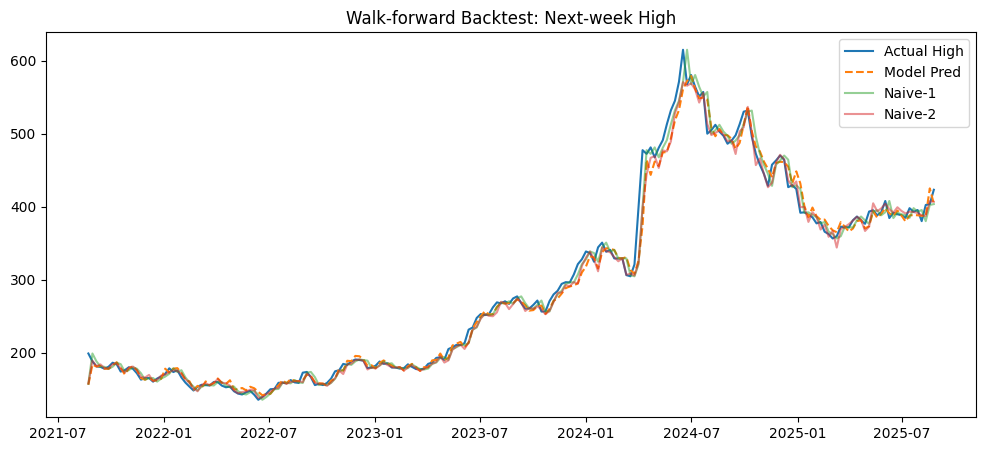

Close                0.813738
Low                  0.074850
High                 0.053188
Open                 0.017121
vol_26w              0.013387
EMA5                 0.003764
MACD_hist            0.002725
MACD                 0.002329
STOCHK14             0.002311
Range                0.001810
Vol_MA13             0.001545
MACD_signal          0.001500
dist_to_52w_low_%    0.001432
ATR14                0.001419
HminusC              0.001346
dtype: float64

In [11]:
# Evaluate
bt_metrics = metrics(true_vals, preds)
b1_metrics = metrics(true_vals, naive1_preds)
b2_metrics = metrics(true_vals, naive2_preds)

print("Walk-forward Model:", bt_metrics)
print("Baseline Naive-1  :", b1_metrics)
print("Baseline Naive-2  :", b2_metrics)

# Plot backtest
fig, ax = plt.subplots()
ax.plot(pred_dates, true_vals, label='Actual High')
ax.plot(pred_dates, preds, label='Model Pred', linestyle='--')
ax.plot(pred_dates, naive1_preds, label='Naive-1', alpha=0.5)
ax.plot(pred_dates, naive2_preds, label='Naive-2', alpha=0.5)
ax.legend()
ax.set_title("Walk-forward Backtest: Next-week High")
plt.show()

# Feature importance (rough guidance)
model_final = GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=3, subsample=0.8, random_state=42
)
model_final.fit(X[:initial_train_weeks], y[:initial_train_weeks])
imp = pd.Series(model_final.feature_importances_, index=feat_cols).sort_values(ascending=False)
imp.head(15)


In [12]:
# ========= CELL 8: Decomposition (Optional) =========
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Build uplift target
data2 = df.copy()
data2['uplift'] = data2['High'] - data2['Close']
data2['uplift_next'] = data2['uplift'].shift(-1)

# reuse technical features + some uplift-specific
feat_cols_uplift = feat_cols + ['HminusC','Range','ATR14','RSI14','vol_13w','vol_26w']
feat_cols_uplift = [c for c in feat_cols_uplift if c in data2.columns]

super_u = data2[feat_cols_uplift + ['uplift_next','Close']].dropna().copy()
super_u['Date'] = super_u.index
super_u = super_u.reset_index(drop=True)

Xu = super_u[feat_cols_uplift].values
yu = super_u['uplift_next'].values
Cl = super_u['Close'].values
Dt = super_u['Date'].values

initial_train_weeks = 260

preds_u, true_u, dates_u = [], [], []

for i in range(initial_train_weeks, len(yu)-1):
    # 1) forecast Close_{t+1} using Holt-Winters on Close up to i (expanding)
    close_train = Cl[:i]
    # Add small epsilon to avoid numerical issues if constant periods
    try:
        hw = ExponentialSmoothing(close_train, trend='add', seasonal=None).fit(optimized=True)
        close_hat_next = hw.forecast(1)[0]
    except Exception:
        close_hat_next = close_train[-1]  # fallback

    # 2) predict uplift_{t+1} with GBM on features up to i
    X_tr, y_tr = Xu[:i], yu[:i]
    X_te = Xu[i:i+1]
    model_u = GradientBoostingRegressor(
        n_estimators=500, learning_rate=0.03, max_depth=3, subsample=0.8, random_state=42
    )
    model_u.fit(X_tr, y_tr)
    uplift_hat_next = model_u.predict(X_te)[0]

    # combine
    high_hat_next = close_hat_next + uplift_hat_next

    # true next-week high (aligned)
    true_next_high = df['High'].reindex([Dt[i] + pd.Timedelta(days=0)]).values  # we will align differently below

    preds_u.append(high_hat_next)
    true_u.append(y[i])  # use the same y from supervised High target alignment
    dates_u.append(Dt[i])



In [13]:
preds_u = [i[0] for i in preds_u]  # flatten
print(len(preds_u), len(true_u), len(dates_u))

print(true_u)
print(preds_u)


210 210 210
[np.float64(199.09601444188763), np.float64(188.3104540285332), np.float64(181.2658022566013), np.float64(180.73139549547253), np.float64(178.15645377765017), np.float64(180.97429306931448), np.float64(186.4642555899217), np.float64(184.4237440190852), np.float64(174.31833871750777), np.float64(176.2616676407432), np.float64(180.19697477225205), np.float64(178.2536150057515), np.float64(171.9863135934449), np.float64(163.28984473735778), np.float64(165.2331831982082), np.float64(165.47609116378655), np.float64(160.5691473912633), np.float64(164.7959218866526), np.float64(167.5166168409723), np.float64(171.3547499883435), np.float64(178.83662260210116), np.float64(173.6867425971598), np.float64(176.16453444157167), np.float64(166.30201568420378), np.float64(159.17409258224433), np.float64(153.66839614952758), np.float64(148.40846690210918), np.float64(153.71755589793696), np.float64(156.2245955501006), np.float64(155.83133981318946), np.float64(155.29059442451663), np.float6

Decomposition (Closê + Uplift̂) backtest: {'RMSE': 354.1263376404301, 'MAE': 11.522405697896257, 'MAPE%': np.float64(3.7641641743706877), 'SMAPE%': np.float64(3.8155884344919846)}


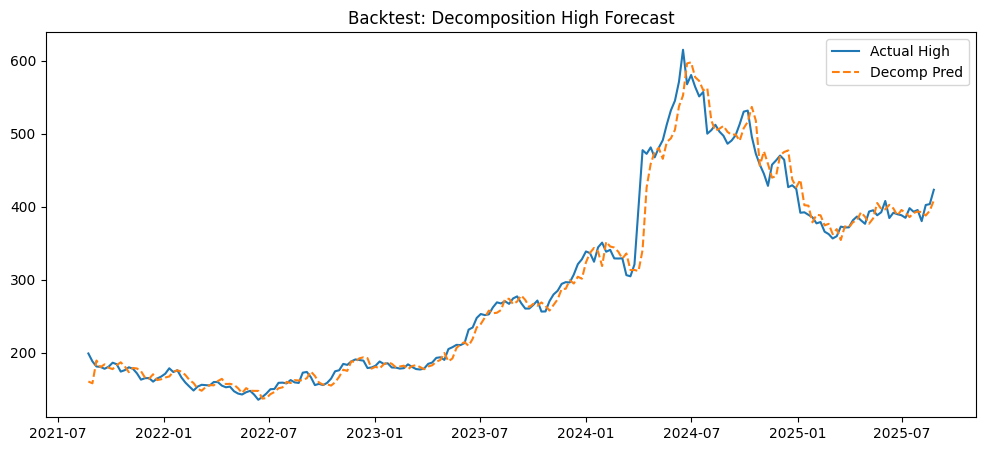

In [14]:
# Evaluate decomposition on same alignment
dec_metrics = metrics(true_u, preds_u)
print("Decomposition (Closê + Uplift̂) backtest:", dec_metrics)

fig, ax = plt.subplots()
ax.plot(dates_u, true_u, label='Actual High')
ax.plot(dates_u, preds_u, label='Decomp Pred', linestyle='--')
ax.legend()
ax.set_title("Backtest: Decomposition High Forecast")
plt.show()


In [15]:
# ========= CELL 9: Final fit and Forecast (Direct Model) =========
# Training on all rows except the very last (no y_target for it due to shift)
X_all = supervised[feat_cols].values
y_all = supervised['y_target'].values
dates_all = supervised['Date'].values

model_final = GradientBoostingRegressor(
    n_estimators=700, learning_rate=0.03, max_depth=3, subsample=0.9, random_state=42
)
model_final.fit(X_all, y_all)

# Build the "last row" of features to predict next week (the last supervised row already predicts next week of that row)
last_feat = df.iloc[[-1]][['Open','High','Low','Close','Volume','Range','HminusC','ret_close',
                           'vol_13w','vol_26w','ATR14','RSI14','EMA5','EMA10','EMA20','EMA50',
                           'MACD','MACD_signal','MACD_hist','STOCHK14',
                           'dist_to_52w_high_%','dist_to_52w_low_%','Vol_MA13','Vol_surge']].copy()

# Align to selected feat_cols
last_feat = last_feat.reindex(columns=feat_cols, fill_value=np.nan).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

next_high_hat = float(model_final.predict(last_feat.values)[0])
print("Next-week High (model):", round(next_high_hat, 2))

# Baselines for the same next week (use last known week)
last_high = float(df['High'].iloc[-1])
last_close = float(df['Close'].iloc[-1])
median_hc_52 = float((df['High'] - df['Close']).tail(52).median())

baseline1 = last_high
baseline2 = last_close + median_hc_52

print("Baseline-1 (High_t):", round(baseline1, 2))
print("Baseline-2 (Close_t + median(H-C)_52w):", round(baseline2, 2))

# sanity: High should be >= last Close (not a hard rule, but usually)
if next_high_hat < last_close:
    print("Note: Predicted High is below last Close. Consider capping to at least last Close for sanity.")


Next-week High (model): 425.26
Baseline-1 (High_t): 431.0
Baseline-2 (Close_t + median(H-C)_52w): 432.65


C:\Users\Ammar Fitwalla\AppData\Local\Temp\ipykernel_21216\1858672024.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  last_feat = last_feat.reindex(columns=feat_cols, fill_value=np.nan).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
C:\Users\Ammar Fitwalla\AppData\Local\Temp\ipykernel_21216\1858672024.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  last_feat = last_feat.reindex(columns=feat_cols, fill_value=np.nan).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


In [16]:
# X0 — Import/Install XGBoost
try:
    from xgboost import XGBRegressor
except Exception as e:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    from xgboost import XGBRegressor

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [18]:
def mape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    mask = y != 0
    return (np.abs((y[mask]-yhat[mask])/y[mask]).mean() * 100)

def smape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    denom = (np.abs(y) + np.abs(yhat)) / 2
    mask = denom != 0
    return (np.abs(y - yhat)[mask] / denom[mask]).mean() * 100


In [ ]:
# A1 — Lean feature set (avoid raw price dominance), build supervised with log target
data = df.copy()

# Ensure both are timezone-naive before loop
dates = pd.to_datetime(dates).tz_localize(None)
data.index = pd.to_datetime(data.index).tz_localize(None)

# If not already made in your indicators cell:
if 'EMA5' not in data.columns:  # quick safety
    raise ValueError("Please run your indicators cell first (ATR14, RSI14, EMAs, MACD, STOCHK14, vol_13w/26w, Range, HminusC, Vol_surge).")

data['EMA5_10_diff']  = data['EMA5']  - data['EMA10']
data['EMA10_20_diff'] = data['EMA10'] - data['EMA20']
data['EMA20_50_diff'] = data['EMA20'] - data['EMA50']

feat_cols_v1 = [
    'Range','HminusC','ATR14','vol_13w','vol_26w',
    'RSI14','MACD_hist','STOCHK14',
    'dist_to_52w_high_%','dist_to_52w_low_%',
    'Vol_surge','EMA5_10_diff','EMA10_20_diff','EMA20_50_diff'
]
feat_cols_v1 = [c for c in feat_cols_v1 if c in data.columns]

super_v1 = data[feat_cols_v1 + ['High','Close']].copy()
super_v1['y_target'] = np.log1p(super_v1['High'].shift(-1))  # predict High_{t+1}
super_v1 = super_v1.dropna().copy()
super_v1['Date'] = super_v1.index

X = super_v1[feat_cols_v1].values
y = super_v1['y_target'].values
dates = super_v1['Date'].values

# Baseline helpers (original scale)
hc_spread = (df['High'] - df['Close'])
med_hc_52 = hc_spread.rolling(52).median()


In [32]:
# ---------- A1: PREP & FEATURES ----------
data = df.copy()  # work on a copy to keep raw df safe

# ensure indicators exist
if 'EMA5' not in data.columns:
    raise ValueError("Run your indicators cell first (ATR14, RSI14, EMAs, MACD, STOCHK14, vol_13w/26w, Range, HminusC, Vol_surge).")

# feature engineering
data['EMA5_10_diff']  = data['EMA5']  - data['EMA10']
data['EMA10_20_diff'] = data['EMA10'] - data['EMA20']
data['EMA20_50_diff'] = data['EMA20'] - data['EMA50']

feat_cols_v1 = [
    'Range','HminusC','ATR14','vol_13w','vol_26w',
    'RSI14','MACD_hist','STOCHK14',
    'dist_to_52w_high_%','dist_to_52w_low_%',
    'Vol_surge','EMA5_10_diff','EMA10_20_diff','EMA20_50_diff'
]
feat_cols_v1 = [c for c in feat_cols_v1 if c in data.columns]

# supervised target: log(High_{t+1})
super_v1 = data[feat_cols_v1 + ['High','Close']].copy()
super_v1['y_target'] = np.log1p(super_v1['High'].shift(-1))
super_v1 = super_v1.dropna().copy()

# ---- Fix timezone issues (strip tz info safely) ----
super_v1.index = pd.to_datetime(super_v1.index.strftime('%Y-%m-%d %H:%M:%S'))
data.index      = pd.to_datetime(data.index.strftime('%Y-%m-%d %H:%M:%S'))

# extract arrays
super_v1['Date'] = super_v1.index
X = super_v1[feat_cols_v1].values
y = super_v1['y_target'].values
dates = super_v1['Date'].values

# baselines: median High-Close spread over 52 weeks
med_hc_52 = (data['High'] - data['Close']).rolling(52).median()

# ---------- A2: WALK-FORWARD BACKTEST ----------
ROLL_WEEKS = 208  # ~4 years
preds, truth, pred_dates = [], [], []
naive1_preds, naive2_preds = [], []

print("Sizes ->", len(y), len(X), len(dates))

for i in range(ROLL_WEEKS, len(y)-1):
    X_train, y_train = X[i-ROLL_WEEKS:i], y[i-ROLL_WEEKS:i]
    X_test, y_test   = X[i:i+1], y[i:i+1]
    d = dates[i]  # already timezone-naive

    # XGBRegressor
    xgb = XGBRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_train, y_train)
    yhat_log = float(xgb.predict(X_test)[0])
    yhat = float(np.expm1(yhat_log))       # back to High scale
    true_high = float(np.expm1(y_test[0]))

    print(f"Week {i} | Date: {d} | True High: {true_high:.2f} | Pred High: {yhat:.2f}")

    preds.append(yhat); truth.append(true_high); pred_dates.append(d)

    # --- Baselines (naive) ---
    j = data.index.get_indexer([pd.Timestamp(d)], method='nearest')[0]
    last_high  = float(data['High'].iloc[j])
    last_close = float(data['Close'].iloc[j])
    med52_val  = med_hc_52.iloc[j]
    med52      = float(med52_val) if not np.isnan(med52_val) else (last_high - last_close)

    print(f"  Baselines: Naive-1 (High_t): {last_high:.2f}, Naive-2 (Close_t + median(H-C)_52w): {last_close + med52:.2f}")

    naive1_preds.append(last_high)
    naive2_preds.append(last_close + med52)

    # break  # remove to run full backtest

# ---------- METRICS ----------
if len(preds) > 0:
    print("Direct XGB — metrics:",
          {"RMSE": mean_squared_error(truth, preds),
           "MAE":  mean_absolute_error(truth, preds),
           "MAPE%": mape(truth, preds),
           "SMAPE%": smape(truth, preds)})
else:
    print("No predictions made. Remove the `break` to run full backtest.")


Sizes -> 471 471 471
Week 208 | Date: 2020-08-24T00:00:00.000000000 | True High: 167.56 | Pred High: 178.07
  Baselines: Naive-1 (High_t): 171.65, Naive-2 (Close_t + median(H-C)_52w): 170.30
Week 209 | Date: 2020-08-31T00:00:00.000000000 | True High: 158.42 | Pred High: 179.79
  Baselines: Naive-1 (High_t): 167.56, Naive-2 (Close_t + median(H-C)_52w): 162.40
Week 210 | Date: 2020-09-07T00:00:00.000000000 | True High: 163.09 | Pred High: 188.26
  Baselines: Naive-1 (High_t): 158.42, Naive-2 (Close_t + median(H-C)_52w): 154.70
Week 211 | Date: 2020-09-14T00:00:00.000000000 | True High: 160.59 | Pred High: 194.55
  Baselines: Naive-1 (High_t): 163.09, Naive-2 (Close_t + median(H-C)_52w): 165.86
Week 212 | Date: 2020-09-21T00:00:00.000000000 | True High: 161.07 | Pred High: 181.76
  Baselines: Naive-1 (High_t): 160.59, Naive-2 (Close_t + median(H-C)_52w): 159.94
Week 213 | Date: 2020-09-28T00:00:00.000000000 | True High: 162.46 | Pred High: 170.71
  Baselines: Naive-1 (High_t): 161.07, Nai

[171.65133958333493, 167.5621020119111, 158.42148879174707, 163.0880267908755, 160.58636418377668, 161.0674555554009, 162.46261342921355, 159.0469006517252, 157.17067107483908, 159.38366190367935, 158.758234704899, 165.3010103947449, 166.3594049675964, 179.34869914036202, 181.7541162705258, 187.62336872947063, 189.9806986360913, 185.4103836402116, 186.1801276666597, 194.16615215041853, 201.28620253200083, 199.07321664379492, 197.43754645958012, 201.0937722422594, 213.08811732558468, 209.2985961791822, 203.61431723780748, 205.5576643425166, 202.49687590605, 197.2498380587625, 185.58974000327595, 182.62614169638067, 183.84075537806865, 179.75970845826916, 171.01464576156158, 177.57344736137847, 180.1969518828129, 185.10393237533776, 183.9865109641946, 189.1363678351312, 189.23352606603984, 193.36314507415943, 188.50479294342463, 182.4804133687107, 179.9540404214999, 181.41154319799128, 179.75972692861598, 178.54512577742338, 175.87300911871756, 175.33859093214633, 168.19679069955714, 162

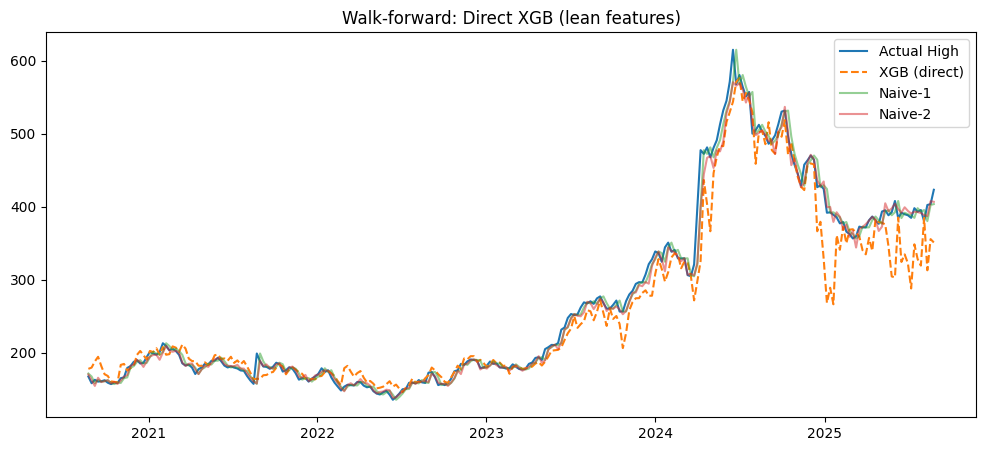

In [34]:
print(naive1_preds)
print(naive2_preds)
print("Naive-1 RMSE:", mean_squared_error(truth, naive1_preds))
print("Naive-2 RMSE:", mean_squared_error(truth, naive2_preds))
print("Naive-1 MAPE%:", mape(truth, naive1_preds))
print("Naive-2 MAPE%:", mape(truth, naive2_preds))
print("Naive-1 SMAPE%:", smape(truth, naive1_preds))
print("Naive-2 SMAPE%:", smape(truth, naive2_preds))

print('xgboost RMSE:', mean_squared_error(truth, preds))
print('xgboost MAPE%:', mape(truth, preds))
print('xgboost SMAPE%:', smape(truth, preds))


# Plot
fig, ax = plt.subplots()
ax.plot(pred_dates, truth, label='Actual High')
ax.plot(pred_dates, preds, '--', label='XGB (direct)')
ax.plot(pred_dates, naive1_preds, alpha=0.5, label='Naive-1')
ax.plot(pred_dates, naive2_preds, alpha=0.5, label='Naive-2')
ax.legend(); ax.set_title("Walk-forward: Direct XGB (lean features)"); plt.show()

In [35]:
# A3 — Fit on latest roll block to peek importance
xgb_tmp = XGBRegressor(
    n_estimators=800, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.8, objective="reg:squarederror",
    random_state=42, n_jobs=-1
)
xgb_tmp.fit(X[len(y)-ROLL_WEEKS-1:len(y)-1], y[len(y)-ROLL_WEEKS-1:len(y)-1])
imp = pd.Series(xgb_tmp.feature_importances_, index=feat_cols_v1).sort_values(ascending=False)
imp.head(15)


ATR14                 0.661735
EMA20_50_diff         0.133479
Range                 0.062895
dist_to_52w_high_%    0.040569
dist_to_52w_low_%     0.039528
vol_26w               0.036982
MACD_hist             0.010707
EMA10_20_diff         0.007326
vol_13w               0.001590
HminusC               0.001467
STOCHK14              0.001448
RSI14                 0.001169
Vol_surge             0.000758
EMA5_10_diff          0.000345
dtype: float32

In [36]:
# B1 — Uplift dataset (+ basic lags)
u = df.copy()
u['uplift'] = u['High'] - u['Close']
u['uplift_next'] = u['uplift'].shift(-1)

u['uplift_lag1'] = u['uplift'].shift(1)
u['ATR14_lag1']  = u['ATR14'].shift(1)
u['Range_lag1']  = u['Range'].shift(1)
u['vol13_lag1']  = u['vol_13w'].shift(1)

feat_cols_u = [
    'uplift','uplift_lag1','ATR14','ATR14_lag1',
    'Range','Range_lag1','vol_13w','vol13_lag1',
    'RSI14','MACD_hist','STOCHK14','Vol_surge',
    'dist_to_52w_high_%','dist_to_52w_low_%'
]
feat_cols_u = [c for c in feat_cols_u if c in u.columns]

super_u = u[feat_cols_u + ['uplift_next','Close','High']].dropna().copy()
super_u['Date'] = super_u.index

Xu = super_u[feat_cols_u].values
yu = super_u['uplift_next'].values
Cl = super_u['Close'].values
Dt = super_u['Date'].values

hc_spread = (df['High'] - df['Close'])
med_hc_52 = hc_spread.rolling(52).median()


2020-08-30 18:30:00 | true=158.42 pred=165.81 | n1=167.56 n2=162.40
2020-09-06 18:30:00 | true=163.09 pred=153.44 | n1=158.42 n2=154.70
2020-09-13 18:30:00 | true=160.59 pred=168.45 | n1=163.09 n2=165.86
2020-09-20 18:30:00 | true=161.07 pred=161.97 | n1=160.59 n2=159.94
2020-09-27 18:30:00 | true=162.46 pred=159.19 | n1=161.07 n2=161.31
2020-10-04 18:30:00 | true=159.05 pred=161.96 | n1=162.46 n2=162.51
2020-10-11 18:30:00 | true=157.17 pred=160.92 | n1=159.05 n2=158.13
2020-10-18 18:30:00 | true=159.38 pred=159.73 | n1=157.17 n2=160.23
2020-10-25 18:30:00 | true=158.76 pred=157.91 | n1=159.38 n2=157.41
2020-11-01 18:30:00 | true=165.30 pred=165.24 | n1=158.76 n2=162.29
2020-11-08 18:30:00 | true=166.36 pred=169.62 | n1=165.30 n2=167.30
2020-11-15 18:30:00 | true=179.35 pred=170.08 | n1=166.36 n2=169.61
2020-11-22 18:30:00 | true=181.75 pred=183.69 | n1=179.35 n2=182.11
2020-11-29 18:30:00 | true=187.62 pred=187.22 | n1=181.75 n2=183.85
2020-12-06 18:30:00 | true=189.98 pred=191.48 | 

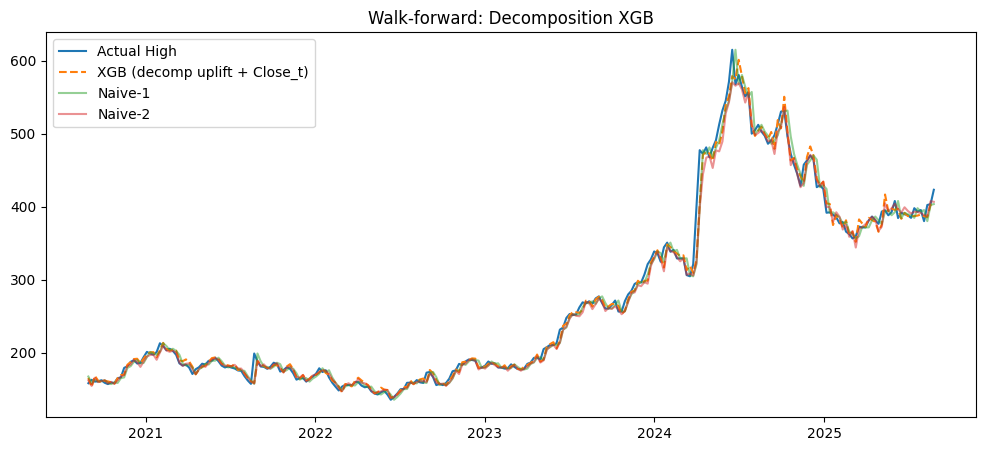

In [49]:
# ----- B2 — Walk-forward (uplift XGB + Close_t) [robust indexing + true_next fix] -----
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    mask = y != 0
    return (np.abs((y[mask] - yhat[mask]) / y[mask]).mean() * 100)

def smape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    denom = (np.abs(y) + np.abs(yhat)) / 2
    mask = denom != 0
    return (np.abs(y - yhat)[mask] / denom[mask]).mean() * 100

ROLL_WEEKS = 208

preds_u, truth_u, dates_u = [], [], []
naive1_preds, naive2_preds = [], []

for i in range(ROLL_WEEKS, len(yu) - 1):
    X_tr, y_tr = Xu[i-ROLL_WEEKS:i], yu[i-ROLL_WEEKS:i]
    X_te       = Xu[i:i+1]
    d          = pd.Timestamp(Dt[i])

    # Train uplift model
    xgb_u = XGBRegressor(
        n_estimators=800, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.8,
        objective="reg:squarederror", random_state=42, n_jobs=-1
    )
    xgb_u.fit(X_tr, y_tr)
    uplift_hat = float(xgb_u.predict(X_te)[0])

    # Robust index mapping: nearest match to d in df.index
    j = df.index.get_indexer([d], method='nearest')[0]

    # Combine with Close_t
    close_t = float(df['Close'].iloc[j])
    high_hat = close_t + uplift_hat

    # True next week's High = High at index j+1 (one step ahead)
    if j + 1 >= len(df):
        break  # no future label available at end of series
    true_next = float(df['High'].iloc[j + 1])

    # Baselines (use same j)
    last_high  = float(df['High'].iloc[j])
    last_close = float(df['Close'].iloc[j])
    med52_val  = med_hc_52.iloc[j]
    med52      = float(med52_val) if not np.isnan(med52_val) else (last_high - last_close)

    # Store
    preds_u.append(high_hat)
    truth_u.append(true_next)
    dates_u.append(d)
    naive1_preds.append(last_high)
    naive2_preds.append(last_close + med52)

    # Debug (optional)
    print(f"{d} | true={true_next:.2f} pred={high_hat:.2f} | n1={last_high:.2f} n2={last_close + med52:.2f}")

# Metrics (use true RMSE)
print("Decomposition XGB — metrics:",
      {"RMSE": mean_squared_error(truth_u, preds_u),
       "MAE":  mean_absolute_error(truth_u, preds_u),
       "MAPE%": mape(truth_u, preds_u),
       "SMAPE%": smape(truth_u, preds_u)})

print("Naive-1 RMSE:", mean_squared_error(truth_u, naive1_preds))
print("Naive-2 RMSE:", mean_squared_error(truth_u, naive2_preds))

# Plot
fig, ax = plt.subplots()
ax.plot(dates_u, truth_u, label='Actual High')
ax.plot(dates_u, preds_u, '--', label='XGB (decomp uplift + Close_t)')
ax.plot(dates_u, naive1_preds, alpha=0.5, label='Naive-1')
ax.plot(dates_u, naive2_preds, alpha=0.5, label='Naive-2')
ax.legend(); ax.set_title("Walk-forward: Decomposition XGB"); plt.show()


In [57]:
# ===================== FINAL: Next-week High using Decomposition XGB =====================
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# 1) Train uplift model on all history (uses super_u built from u)
Xu_all = super_u[feat_cols_u].values
yu_all = super_u['uplift_next'].values

xgb_u_final = XGBRegressor(
    n_estimators=900,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_u_final.fit(Xu_all, yu_all)

# 2) Build latest feature row from **u** (NOT df)
missing = [c for c in feat_cols_u if c not in u.columns]
if missing:
    raise ValueError(f"These features are missing in `u`: {missing}. Re-run the B1 cell.")

last_feat_u = u[feat_cols_u].copy()
last_feat_u = last_feat_u.ffill().iloc[[-1]]              # features at time T
last_feat_u = last_feat_u.fillna(last_feat_u.median())    # safety: fill any remaining NaNs

# 3) Predict uplift_{T+1} and combine with Close_T
uplift_hat = float(xgb_u_final.predict(last_feat_u.values)[0])
close_t    = float(df['Close'].iloc[-1])
next_high_hat = close_t + uplift_hat

# Enforce basic consistency: High shouldn't be below Close
if next_high_hat < close_t:
    next_high_hat = close_t

# 4) Baselines for context
last_high      = float(df['High'].iloc[-1])
median_hc_52   = float((df['High'] - df['Close']).tail(52).median())
baseline1      = last_high
baseline2      = close_t + median_hc_52

print(f"NEXT WEEK High (Decomp XGB): {next_high_hat:.2f}")
print(f"Baseline-1 (High_t):        {baseline1:.2f}")
print(f"Baseline-2 (Close_t + med(H-C)_52w): {baseline2:.2f}")


NEXT WEEK High (Decomp XGB): 433.07
Baseline-1 (High_t):        431.00
Baseline-2 (Close_t + med(H-C)_52w): 432.65


In [58]:
from sklearn.ensemble import GradientBoostingRegressor

def fit_gbr_q(X, y, alpha):
    return GradientBoostingRegressor(
        loss="quantile", alpha=alpha,
        n_estimators=800, learning_rate=0.03,
        max_depth=3, subsample=0.9, random_state=42
    ).fit(X, y)

Xu_all = super_u[feat_cols_u].values
yu_all = super_u['uplift_next'].values
last_feat_u = u[feat_cols_u].ffill().iloc[[-1]].fillna(u[feat_cols_u].median())
close_t = float(df['Close'].iloc[-1])

gbr_p50 = fit_gbr_q(Xu_all, yu_all, 0.50)
gbr_p80 = fit_gbr_q(Xu_all, yu_all, 0.80)
gbr_p90 = fit_gbr_q(Xu_all, yu_all, 0.90)

uplift_p50 = max(0.0, float(gbr_p50.predict(last_feat_u.values)[0]))
uplift_p80 = max(0.0, float(gbr_p80.predict(last_feat_u.values)[0]))
uplift_p90 = max(0.0, float(gbr_p90.predict(last_feat_u.values)[0]))

print(f"P50 High: {close_t + uplift_p50:.2f}")
print(f"P80 High: {close_t + uplift_p80:.2f}")
print(f"P90 High: {close_t + uplift_p90:.2f}")


P50 High: 430.98
P80 High: 434.39
P90 High: 436.41
